In [66]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn import tree
from sklearn import ensemble
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.io import loadmat
import random

%matplotlib inline

In [4]:
cd data

/Users/mbmerrit/Desktop/ML_UQ_repo/machine_learning/data


# Dimension Reduction for Classification Tree Algorithms

Our goal is to investigate the effects of dimension reduction methods (PCA, t-SNE, etc.) on the robustness and efficiency of classification and decision tree methods. We will test these methods on a high dimensional dataset from the UC-Irvine Machine Learning Repository. We use the **Winnipeg cropland dataset**, which organizes features of cropland in Winnipeg, in order to classify the cropland into one of 7 categories: 1-Corn; 2-Peas; 3-Canola; 4-Soybeans; 5-Oats; 6-Wheat; and 7-Broadleaf.

We will begin by citing the paper *Dimension Reduction for Classification: Comparison of Techniques and Dimension Choice* by Plastria, De Bruyne, and Carrizosa from 2008. It is well known and clearly explained in this article, that classification methods are high sensitive to small changes in the training data. Thus, a small perturbation of the training data can result in a very different structure of the resulting tree. Random Forest (RF) models have been developed to cope with this "ill-conditioning" property of classification methods. RF models construct multiple trees by subsetting the data, then they determine the final classification by majority vote. In doing so, they average over several different classification methods. 

Our goal is not to make classifiers more robust by generating multiple using a RF approach, but to make more robust classifiers by reducing the overall dimension of the data. 

For our purposes, we will restrict our investigation to the CART algorithm, which is a variation of the well-known C4.5 classification method. We will consider random forests to set a baseline of classification error. For dimension reduction methods, we will consider here *principal component analysis* (PCA) and t-distributed stochastic neighbor embedding (t-SNE). 

In [67]:
# Import this large dataset
data_full = loadmat('winn.mat')
winn_data = data_full['winn']
winn_X = winn_data[:,1:]
winn_Y = winn_data[:,0]
samples, features = winn_X.shape

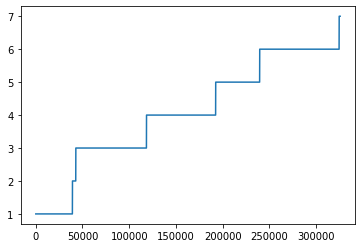

In [68]:
plt.plot(winn_data[:,0])

In [69]:
# This partitions the data into 7000 usable samples, we don't use the rest for now
set1 = list(range(100,2100))
set2 = list(range(40000, 42000))
set3 = list(np.arange(60000,62000))
set4 = list(np.arange(150000,152000))
set5 = list(np.arange(220000,222000))
set6 = list(np.arange(250000,252000))
set7 = list(np.arange(samples-2000,samples))

subset = set1 + set2 + set3 + set4 + set5 + set6 + set7
Y_train = winn_Y[subset]
X_train = winn_X[subset,:]
# This is our training data with 7000 samples and 174 features and 7 classes

# Then we define the training data randomly from our whole dataset
test_size = 10000
test_subset = random.sample(range(1, samples), test_size)
Y_test = winn_Y[test_subset]
X_test = winn_X[test_subset,:]

In [70]:
Y_test

array([4., 4., 4., ..., 1., 5., 6.])

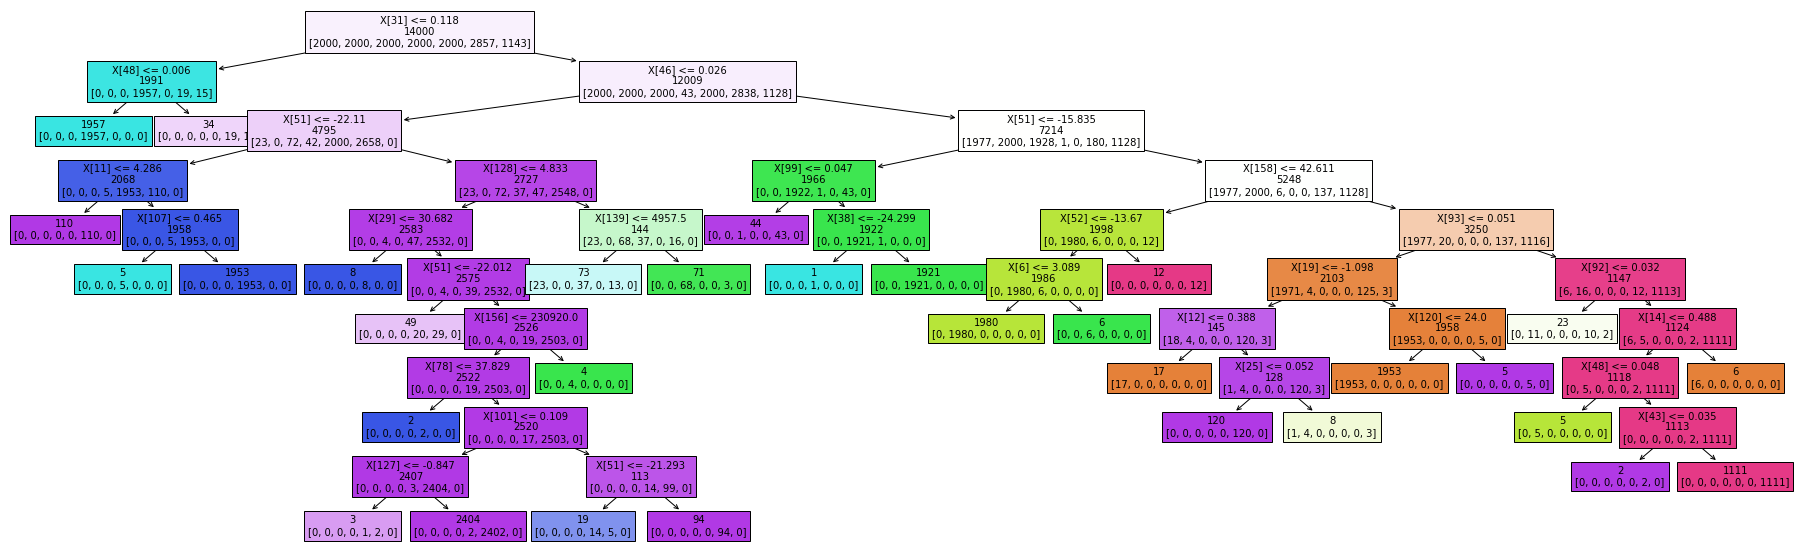

In [71]:
# Then we have a few parameters that can be tuned for these trees
max_d = 10
min_samp = 100

clf = tree.DecisionTreeClassifier(max_depth=max_d, min_samples_split=min_samp)
clf = clf.fit(X_train, Y_train)

plt.figure(figsize=(32,10))
sklearn.tree.plot_tree(clf, fontsize=10, impurity=False, filled=True, label={'all'}); 
#plt.savefig('tree1.png')

In [72]:
correct_percent = np.sum(clf.predict(X_test) == Y_test) / test_size
print('Error percentage in validation: ', (1-correct_percent)*100)

# So this initial tree is 80 percent correct

Error percentage in validation:  21.120000000000005


In [73]:
# Now we do the same exercise with a random forest. This will give us a baseline for accuracy
rf_size = 50

rf_clf = sklearn.ensemble.RandomForestClassifier(n_estimators=rf_size, max_depth=10, min_samples_split=100)
rf_clf.fit(X_train, Y_train)

correct_percent_rf = np.sum(rf_clf.predict(X_test) == Y_test) / test_size
print('Error percentage in validation: ', (1-correct_percent_rf)*100, 'for number of trees: ',rf_size)

# This is a good baseline to shoot for, about 15 percent error

Error percentage in validation:  16.51 for number of trees:  50


# Dimension Reduction Task 1: Principal Components Analysis (PCA)

We begin by using PCA to reduce the dimension of the feature space, currently at 174. PCA uses the singular value decomposition (SVD) from linear algebra to find vectors in the direction of greatest variance in the data, and will allow us to reduce this dataset and hopefully improve the performance of the classifiers. 

In [74]:
winn_pca = PCA(n_components=features, )
winn_pca.fit(X_train)
X_train_transf = winn_pca.transform(X_train)

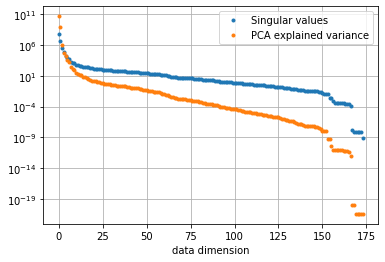

In [75]:
# This plot is similar to the singular value decay, which here hits 10 around component 10
u, s, vh = np.linalg.svd(X_train, full_matrices=True)
plt.semilogy(s, '.')
plt.semilogy(winn_pca.explained_variance_, '.')
plt.legend(['Singular values','PCA explained variance'])
plt.xlabel('data dimension')
plt.grid()
#plt.savefig('PCA_SVD_decay.pdf')

# the orange plot is the singular value decay. I believe the PCA just normalizes before it computes the SVD

In [76]:
np.sum(winn_pca.explained_variance_ratio_[:10])/np.sum(winn_pca.explained_variance_ratio_)

0.9999999978559901

In [77]:
var_tolerance = 30
important_components = np.sum((winn_pca.explained_variance_ > var_tolerance))
print('Use the first ', important_components, 'components to reduce the variance')
# The first 22 modes of the PCA have a value above 1, this is our threshold

num_target_features = important_components # this should capture most of the data variance
winn_pca_RD = PCA(n_components=num_target_features, )
winn_pca_RD.fit(X_train)
X_train_transf = winn_pca_RD.transform(X_train)

Use the first  10 components to reduce the variance


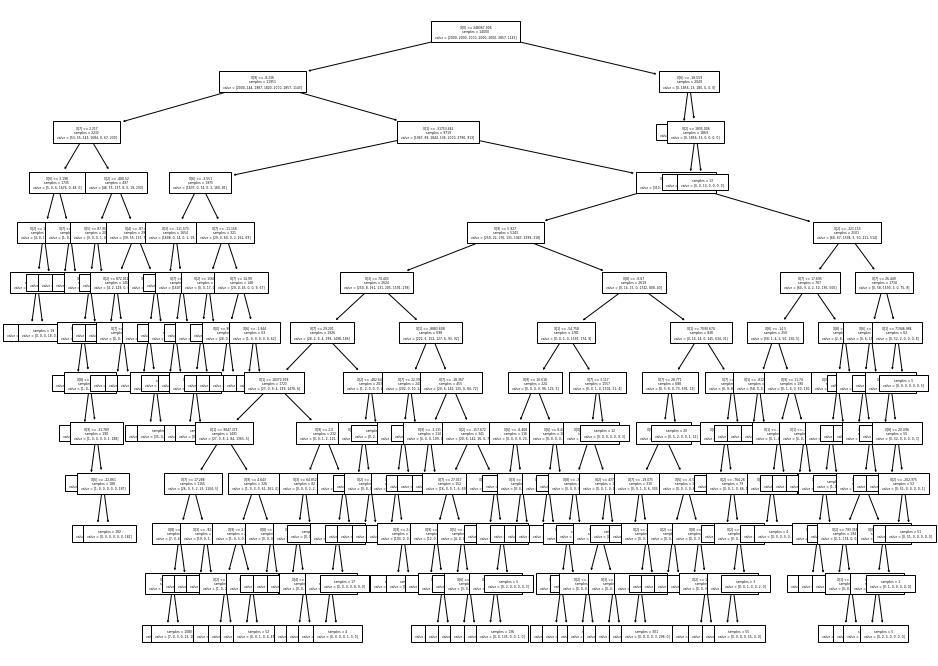

In [78]:
max_d = 12
min_samp = 50

clf_RD = tree.DecisionTreeClassifier(max_depth=max_d, min_samples_split=min_samp)
clf_RD = clf_RD.fit(X_train_transf, Y_train)

plt.figure(figsize=(16,12))
sklearn.tree.plot_tree(clf_RD, fontsize=3, impurity=False); 

In [79]:
correct_percent = np.sum(clf_RD.predict(winn_pca_RD.transform(X_test)) == Y_test) / test_size
print('Error percentage in validation: ', (1-correct_percent)*100)

# So going from 174 to 22 features, our validation error only increases by about 4. 
# But is our classifier now more robust to perturbations in training data?

Error percentage in validation:  19.88


In [80]:
# Test the error percentage in classification using an increasing number of PCA modes
correct_percent_pca = np.zeros((174,))

for i in range(1,174):
    winn_pca_RD = PCA(n_components=i, )
    winn_pca_RD.fit(X_train)
    X_train_transf = winn_pca_RD.transform(X_train)
    clf_RD = tree.DecisionTreeClassifier(max_depth=max_d, min_samples_split=min_samp)
    clf_RD = clf_RD.fit(X_train_transf, Y_train)
    correct_percent_pca[i] = np.sum(clf_RD.predict(winn_pca_RD.transform(X_test)) == Y_test) / test_size
    print('Error percentage in validation: ', (1-correct_percent_pca[i])*100, ' for PCA with ', i, ' modes')                  

Error percentage in validation:  63.85000000000001  for PCA with  1  modes
Error percentage in validation:  49.53999999999999  for PCA with  2  modes
Error percentage in validation:  33.03  for PCA with  3  modes
Error percentage in validation:  30.410000000000004  for PCA with  4  modes
Error percentage in validation:  30.95  for PCA with  5  modes
Error percentage in validation:  30.400000000000006  for PCA with  6  modes
Error percentage in validation:  21.409999999999997  for PCA with  7  modes
Error percentage in validation:  19.979999999999997  for PCA with  8  modes
Error percentage in validation:  16.1  for PCA with  9  modes
Error percentage in validation:  20.369999999999997  for PCA with  10  modes
Error percentage in validation:  18.630000000000003  for PCA with  11  modes
Error percentage in validation:  18.45  for PCA with  12  modes
Error percentage in validation:  19.730000000000004  for PCA with  13  modes
Error percentage in validation:  19.689999999999998  for PCA wi

Error percentage in validation:  22.550000000000004  for PCA with  113  modes
Error percentage in validation:  22.540000000000006  for PCA with  114  modes
Error percentage in validation:  23.040000000000006  for PCA with  115  modes
Error percentage in validation:  23.470000000000002  for PCA with  116  modes
Error percentage in validation:  23.229999999999997  for PCA with  117  modes
Error percentage in validation:  22.89  for PCA with  118  modes
Error percentage in validation:  23.07  for PCA with  119  modes
Error percentage in validation:  22.709999999999997  for PCA with  120  modes
Error percentage in validation:  23.080000000000002  for PCA with  121  modes
Error percentage in validation:  21.930000000000007  for PCA with  122  modes
Error percentage in validation:  22.540000000000006  for PCA with  123  modes
Error percentage in validation:  22.140000000000004  for PCA with  124  modes
Error percentage in validation:  23.4  for PCA with  125  modes
Error percentage in valida

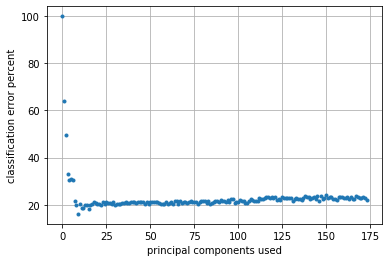

In [81]:
plt.plot((1-correct_percent_pca[:])*100, '.') 
plt.xlabel('principal components used')
plt.ylabel('classification error percent')
plt.grid()
#plt.savefig('pca_misclass_bymode.pdf')

# We can hit 80% correct classification with less than 20 features, closer to 10. 
# Let's use the eyeball norm to see if a tree classified with 10 features will be less sensitive than with all 174

## We examine the robustness of the classifiers and reduced-dimension classifier to perturbed training data. We use the eyeball norm to detect changes in the tree structure

In [82]:
# we start with large data perturbations, training on two very different subsets of the dataset
test_size = 10000 # size of random subset
data_subset_A = random.sample(range(1, samples), test_size)
Y_subset_A = winn_Y[data_subset_A]
X_subset_A = winn_X[data_subset_A,:]

data_subset_B = random.sample(range(1, samples), test_size)
Y_subset_B = winn_Y[data_subset_B]
X_subset_B = winn_X[data_subset_B,:]

reduced_components = 10
full_components = features

In [83]:
# Now transform the data to the reduced dimension and fit both trees, checking error percentages
max_d = 10
min_samp = 10

pca_RD = PCA(n_components=reduced_components, )
pca_RD.fit(winn_X) # train the reduced PCA on the whole dataset

X_subset_A_transf = pca_RD.transform(X_subset_A)
clf_RD_A = tree.DecisionTreeClassifier(max_depth=max_d, min_samples_split=min_samp)
clf_RD_A = clf_RD_A.fit(X_subset_A_transf, Y_subset_A)
print('Error percentage: ', 100-100*np.sum(clf_RD_A.predict(pca_RD.transform(X_test)) == Y_test) / len(Y_test), ' for reduced dimension classifier A')     

X_subset_B_transf = pca_RD.transform(X_subset_B)
clf_RD_B = tree.DecisionTreeClassifier(max_depth=max_d, min_samples_split=min_samp)
clf_RD_B = clf_RD_B.fit(X_subset_B_transf, Y_subset_B)
print('Error percentage: ', 100-100*np.sum(clf_RD_B.predict(pca_RD.transform(X_test)) == Y_test) / len(Y_test), ' for reduced dimension classifier B')  

Error percentage:  8.260000000000005  for reduced dimension classifier A
Error percentage:  8.0  for reduced dimension classifier B


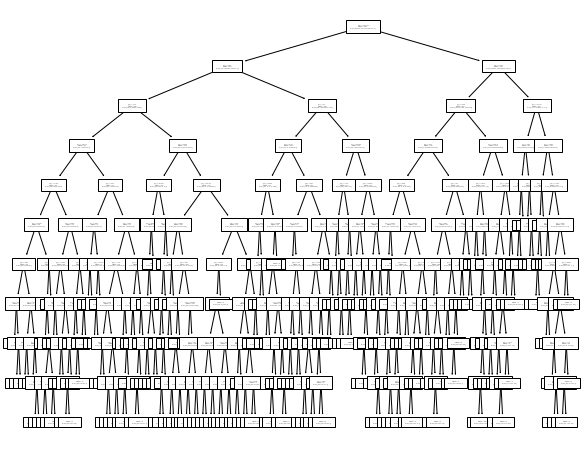

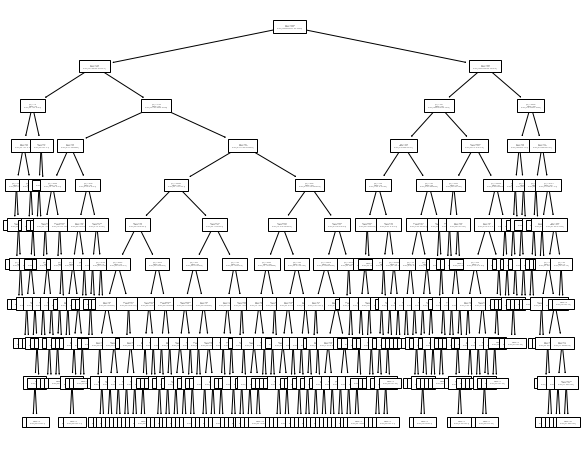

In [84]:
# Finally, we examine the different in the tree structres
plt.figure(figsize=(10,8))
sklearn.tree.plot_tree(clf_RD_A, fontsize=1, impurity=False);
#plt.savefig('tree_struct_pca_A.png')
plt.figure(figsize=(10,8))
sklearn.tree.plot_tree(clf_RD_B, fontsize=1, impurity=False);
#plt.savefig('tree_struct_pca_B.png')

Error percentage:  3.239999999999995  for full dimension classifier A
Error percentage:  3.2900000000000063  for full dimension classifier B


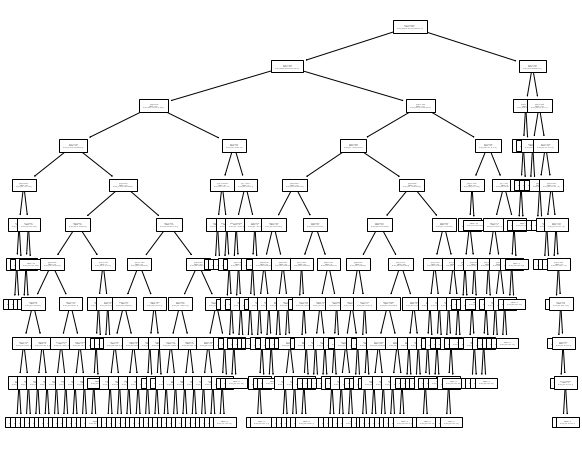

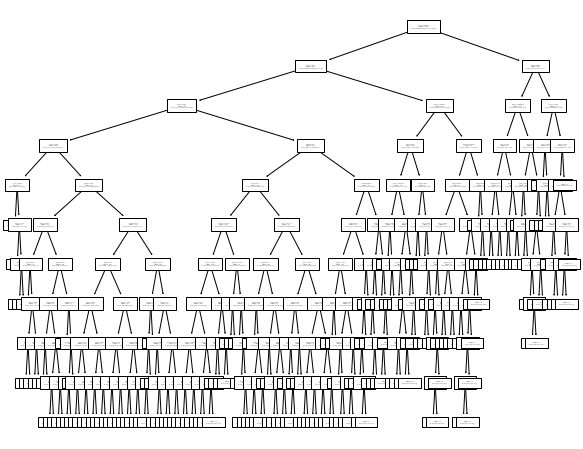

In [85]:
# Now we build trees for the full dimension dataset and look at the their compared structre
min_samp_fulld = int(np.round(min_samp/10))+1

clf_FullD_A = tree.DecisionTreeClassifier(max_depth=max_d, min_samples_split=min_samp_fulld, splitter='random',criterion='entropy')
clf_FullD_A = clf_FullD_A.fit(X_subset_A, Y_subset_A)
print('Error percentage: ', 100-100*np.sum(clf_FullD_A.predict(X_test) == Y_test) / len(Y_test), ' for full dimension classifier A')     

clf_FullD_B = tree.DecisionTreeClassifier(max_depth=max_d, min_samples_split=min_samp_fulld, splitter='random',criterion='entropy')
clf_FullD_B = clf_FullD_B.fit(X_subset_B, Y_subset_B)
print('Error percentage: ', 100-100*np.sum(clf_FullD_B.predict(X_test) == Y_test) / len(Y_test), ' for full dimension classifier B') 

# Now to look at their structure
plt.figure(figsize=(10,8))
sklearn.tree.plot_tree(clf_FullD_A, fontsize=1, impurity=False);
#plt.savefig('tree_struct_full_A.png')
plt.figure(figsize=(10,8))
sklearn.tree.plot_tree(clf_FullD_B, fontsize=1, impurity=False);
#plt.savefig('tree_struct_full_B.png')

## A benchmark on training a classifier with the whole dataset, it takes a while. Remember, our goal in using dimension reduction is not only robustness of the classifier to perturbations in training data, but also computational efficiency in the time it takes to build the classifier. 

In [87]:
# Buidlng a single tree with the full Winn dataset: time benchmarks

# max_d, min_samp: time
# 100, 100: 1min 50s
# 100, 1000: 1min 46s
# 50, 1000: 1min 46s
# 50, 10: 42s
# 1000, 1000: 1min 46s
# 100000, 10: 1min 47s

In [88]:
%%time
max_d = 1000
min_samp = 1000

clf_fulldata = tree.DecisionTreeClassifier(max_depth=max_d, min_samples_split=min_samp)
clf_fulldata = clf_fulldata.fit(winn_X, winn_Y)

#plt.figure(figsize=(16,12))
#sklearn.tree.plot_tree(clf_fulldata, fontsize=10, impurity=False); 

CPU times: user 1min 47s, sys: 605 ms, total: 1min 48s
Wall time: 1min 49s


### Now we do the same with a random forest model and give some time, benchmarks

In [89]:
%%time
rf_size = 25
# RF size 25: 1min 55s, RF size 50: 3min 49s, RF size 100: 7min45s, RF size 500: 39min
rf_clf = sklearn.ensemble.RandomForestClassifier(n_estimators=rf_size, max_depth=1000, min_samples_split=1000)
rf_clf.fit(winn_X, winn_Y)

CPU times: user 1min 59s, sys: 662 ms, total: 2min
Wall time: 2min 1s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=1000,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [90]:
%%time
# Now a random forest with reduced dimension data, this is a much faster process because the linear algebra
# required to transform the X data to a reduced dimension is incredibly fast
winn_X_transf = pca_RD.transform(winn_X)

rf_size = 25
# RF size 25: 34s, RF size 50: 1min 6s, RF size 100: 2min 9s,  RF size 500: 11min 2s
rf_RD_fullset = sklearn.ensemble.RandomForestClassifier(n_estimators=rf_size, max_depth=1000, min_samples_split=1000)
rf_RD_fullset.fit(winn_X_transf, winn_Y)

CPU times: user 31.4 s, sys: 652 ms, total: 32 s
Wall time: 32.3 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=1000,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Introducing a new Sensitivity Analysis  metric

### We next create a metric for change in the structure of a classification tree. So far, we have been measuring this by eye, but we want a more quantitative measure. 

We start by looking at the volume of the feature space apportioned to each class labeling. So given a feature space $\mathcal{X} \subseteq \mathbb{R}^d$ and a features vector $x \in \mathcal{X}$, we can define the classifier model $f$ such that $x \mapsto f(x) \in \{c_1, \dots, c_n\}$. We then define the following metric of importance of each class

$$
M_i(f) = \frac{\text{Vol}\left(  x  | f(x) = c_i  \right)}{\text{Vol}(\mathcal{X})}
$$

Then from this definition, we can define the sensitivity of a classifier. Given two different classifiers $f$ and $g$, we define a set of sensitivity indices

$$
S_i(f, g) = |M_i(f) - M_i(g)|
$$

As we can see, a property that is helpful is $0 \leq S_i(f,g) \leq 1,$ for any  $i, f, g$. We also note, if $i = 1,\dots, n$ covers the whole set of $n$ classes, then $\sum_{i=1}^n M_i(f) = 1$ for any $f$. We implement and use this metric below. We will estimate the $M_i$ and $S_i$ indices using Monte Carlo Integration. It can also be computed more reliably using the rule set that defines the classifier.


In [91]:
def ClassMetric(classifier, data=winn_X):
    '''Given a classifier and a dataset that has the appropriate input dimension, we define and compute
    a metric for the size of the classifier. For now, the metric will be the proportion of the input 
    space that is covered by each class, so output would be (Volume of class i / total Volume of space). 
    We are computing this metric using Monte Carlo methods, so you need A LOT of data to be accurate.'''
    target_dimension = classifier.n_features_
    num_classes = classifier.n_classes_
    
    if data.shape[1] != target_dimension:
        new_pca = PCA(n_components=target_dimension, )
        new_pca.fit(data)
        data_dimred = new_pca.transform(data)
    else:
        data_dimred = data
        
    class_output = classifier.predict(data_dimred)
    metric = np.zeros((num_classes,))
    for i in range(num_classes):
        metric[i] = np.sum(class_output == i+1)/len(class_output)
    if np.sum(metric) != 1:
        print('error: metrics do not sum  to 1, sum is: ',np.sum(metric))
    
    return metric

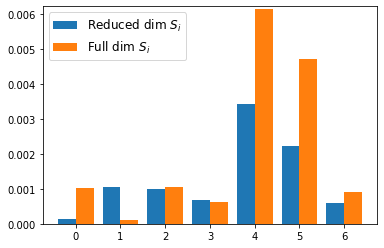

In [112]:
clf_metric_RD_A = ClassMetric(clf_RD_A)
clf_metric_RD_B = ClassMetric(clf_RD_B)

clf_metric_FD_A = ClassMetric(clf_FullD_A)
clf_metric_FD_B = ClassMetric(clf_FullD_B)

clf_metric_fulldata = ClassMetric(clf_fulldata)

plt.bar(np.arange(7)-.2, np.abs(clf_metric_RD_A - clf_metric_RD_B),width=.4)
plt.bar(np.arange(7)+.2, np.abs(clf_metric_FD_A - clf_metric_FD_B),width=.4)
plt.ylim(0, 1.01*np.max(np.abs(clf_metric_FD_A - clf_metric_FD_B)))
plt.legend(('Reduced dim $S_i$','Full dim $S_i$'),fontsize=12)
#plt.savefig('sensitivity_pca.pdf')

In [120]:
# Here is a measure of the relative error in the sensitivity metric w.r.t. the full dataset
RelErr_RD_A = np.abs(clf_metric_RD_A - clf_metric_fulldata) / clf_metric_fulldata
RelErr_FD_A = np.abs(clf_metric_FD_A - clf_metric_fulldata) / clf_metric_fulldata
RelErr_RD_B = np.abs(clf_metric_RD_B - clf_metric_fulldata) / clf_metric_fulldata
RelErr_FD_B = np.abs(clf_metric_FD_B - clf_metric_fulldata) / clf_metric_fulldata

print('Relative Error for A full dimension   :', RelErr_FD_A)
print('Relative Error for A reduced dimension:', RelErr_RD_A)
print('Relative Error for B full dimension   :', RelErr_FD_B)
print('Relative Error for B reduced dimension:', RelErr_RD_B)

Relative Error for A full dimension   : [0.01985491 0.01529312 0.01099354 0.00900204 0.00832688 0.00986145
 0.21902017]
Relative Error for A reduced dimension: [0.0114293  0.02322288 0.0244094  0.01687049 0.01211378 0.00491901
 0.17387128]
Relative Error for B full dimension   : [0.01132748 0.00509771 0.00637519 0.01170932 0.0348567  0.00811637
 0.06243996]
Relative Error for B reduced dimension: [0.01254932 0.07448315 0.02003061 0.01386981 0.01189861 0.00356043
 0.01344861]


error: metrics do not sum  to 1, sum is:  0.9999999999999999
error: metrics do not sum  to 1, sum is:  0.9999999999999999
error: metrics do not sum  to 1, sum is:  0.9999999999999999
error: metrics do not sum  to 1, sum is:  0.9999999999999999
error: metrics do not sum  to 1, sum is:  0.9999999999999999
error: metrics do not sum  to 1, sum is:  0.9999999999999999
error: metrics do not sum  to 1, sum is:  0.9999999999999999
error: metrics do not sum  to 1, sum is:  1.0000000000000002
error: metrics do not sum  to 1, sum is:  1.0000000000000002
error: metrics do not sum  to 1, sum is:  0.9999999999999999
error: metrics do not sum  to 1, sum is:  1.0000000000000002
error: metrics do not sum  to 1, sum is:  0.9999999999999999
error: metrics do not sum  to 1, sum is:  0.9999999999999999
error: metrics do not sum  to 1, sum is:  0.9999999999999999
error: metrics do not sum  to 1, sum is:  1.0000000000000002
error: metrics do not sum  to 1, sum is:  0.9999999999999999
error: metrics do not su

<BarContainer object of 7 artists>

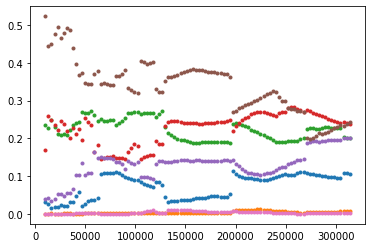

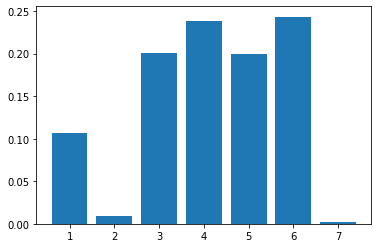

In [121]:
# Here is a convergence plot for the computation of each M_i

listsize = np.round(np.linspace(10000,314000,100)).tolist()
metric_data = np.zeros((len(listsize), 7))
for i in range(len(listsize)):
    clf_metric = ClassMetric(clf_RD_A, winn_X[:int(listsize[i]), :])
    metric_data[i,:] = clf_metric

plt.plot(listsize, metric_data, '.')
plt.figure()
plt.bar(range(1,8), clf_metric)

# Now we move onto the second major dimension reduction technique, t-distributed stochastic neighbor embedding (t-SNE). 

t-SNE is a nonlinear dimension reduction technique, which attempts to find low dimensional structure in the data by minimizing the KL divergence of the probability distributions associated with the high dimensional and low dimensional data representations. We also note that t-SNE works best for moderate dimension data (around 50 dimensions). Dimensions beyond this slow the t-SNE optimization algorithm, so the Python documentation recommends reducing the dimension first using another method, such as PCA, then applying t-SNE. In order to avoid confounding the effects of multiple techniques, we will start by just applying t-SNE to the full Winnipeg data, with 174 dimensions. 

In [122]:
%%time
tSNE = TSNE(n_components=3, learning_rate=200.0, n_iter=1000, n_iter_without_progress=300, \
                  min_grad_norm=1e-07, init='random', verbose=1 )

tSNE_fitted_A = tSNE.fit_transform(X_subset_A)

# Benchmark - 3 components, 500 iterations max: 53.6s
# Must use less than 4 components for the embedded space, interesting...

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.088s...
[t-SNE] Computed neighbors for 10000 samples in 1.336s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 722.053084
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.919304
[t-SNE] KL divergence after 1000 iterations: 0.616180
CPU times: user 6min 33

In [126]:
%%time
tSNE_2 = TSNE(n_components=3, learning_rate=200.0, n_iter=1000, n_iter_without_progress=300, \
                  min_grad_norm=1e-07, init='random', verbose=1 )

tSNE_fitted_B = tSNE_2.fit_transform(X_subset_B)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.103s...
[t-SNE] Computed neighbors for 10000 samples in 1.273s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 706.633679
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.414551
[t-SNE] KL divergence after 1000 iterations: 0.629056
CPU times: user 6min 10

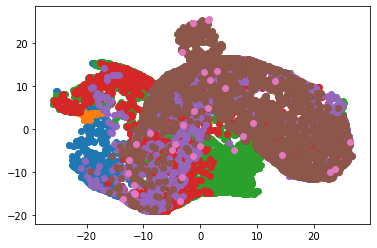

In [163]:
for i in range(1,8):
    idx = list(np.where(Y_subset_A == i)[0])
    plt.scatter(tSNE_fitted_A[idx,0], tSNE_fitted_A[idx,1])
    
#plt.savefig('tSNE_data.pdf')

<IPython.core.display.Javascript object>


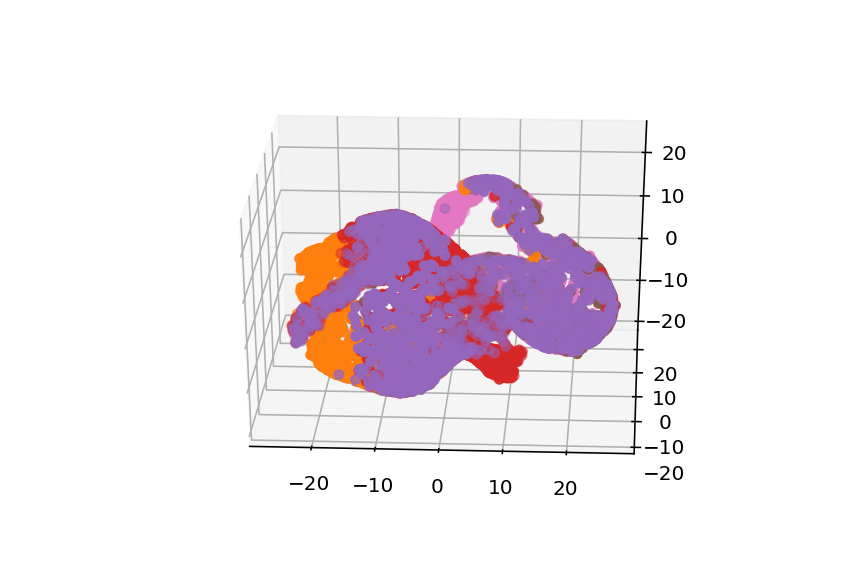

In [164]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(7):
    idx = list(np.where(Y_subset_A == i)[0])
    x =tSNE_fitted_A[idx,0]
    y =tSNE_fitted_A[idx,1]
    z =tSNE_fitted_A[idx,2]

    ax.scatter(x, y, z, marker='o')

In [165]:
# Now transform the data to the reduced dimension and fit both trees, checking error percentages
max_d = 10
min_samp = 100
split = 5000 # cuts the transformed dataset in half

clf_tSNE_A = tree.DecisionTreeClassifier(max_depth=max_d, min_samples_split=min_samp)
clf_tSNE_A = clf_tSNE_A.fit(tSNE_fitted_A[:split,:], Y_subset_A[:split])
print('Error percentage: ', 100-100*np.sum(clf_tSNE_A.predict(tSNE.fit_transform(X_test)) == Y_test) / len(Y_test), ' for reduced dimension classifier A')     

clf_tSNE_B = tree.DecisionTreeClassifier(max_depth=max_d, min_samples_split=min_samp)
clf_tSNE_B = clf_tSNE_B.fit(tSNE_fitted_A[split:,:], Y_subset_B[split:])
print('Error percentage: ', 100-100*np.sum(clf_tSNE_B.predict(tSNE.fit_transform(X_test)) == Y_test) / len(Y_test), ' for reduced dimension classifier B')  

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.099s...
[t-SNE] Computed neighbors for 10000 samples in 1.335s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 712.637596
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.674736
[t-SNE] KL divergence after 1000 iterations: 0.621453
Error percentage:  74.3

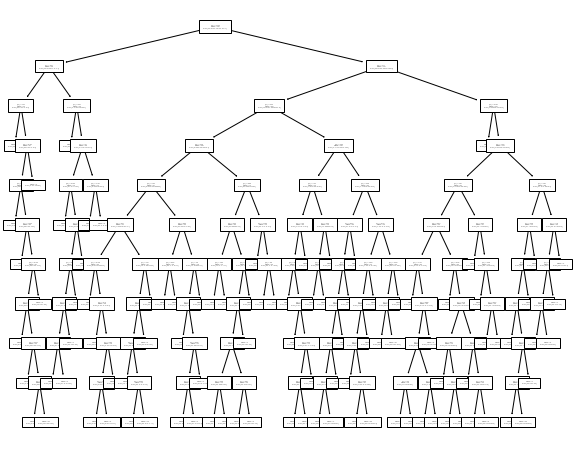

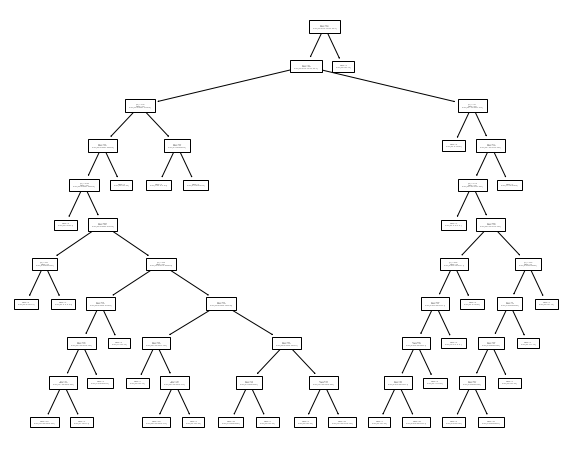

In [166]:
# Now to look at their structure
%matplotlib inline
plt.figure(figsize=(10,8))
sklearn.tree.plot_tree(clf_tSNE_A, fontsize=1, impurity=False);
#plt.savefig('tree_struct_tSNE_A.png')
plt.figure(figsize=(10,8))
sklearn.tree.plot_tree(clf_tSNE_B, fontsize=1, impurity=False);
#plt.savefig('tree_struct_tSNE_B.png')

error: metrics do not sum  to 1, sum is:  1.0000000000000002


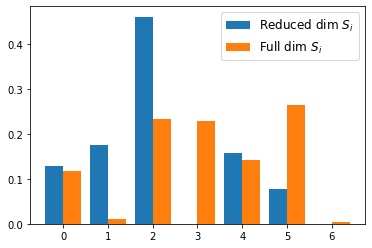

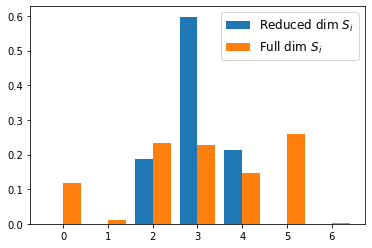

In [173]:
clf_metric_RD_A = ClassMetric(clf_tSNE_A)
clf_metric_RD_B = ClassMetric(clf_tSNE_B)

clf_metric_FD_A = ClassMetric(clf_FullD_A)
clf_metric_FD_B = ClassMetric(clf_FullD_B)

plt.bar(np.arange(7)-.2, clf_metric_RD_A,width=.4)
plt.bar(np.arange(7)+.2, clf_metric_FD_A,width=.4)
plt.legend(('Reduced dim $S_i$','Full dim $S_i$'),fontsize=12)

plt.figure()
plt.bar(np.arange(7)-.2, clf_metric_RD_B,width=.4)
plt.bar(np.arange(7)+.2, clf_metric_FD_B,width=.4)
plt.legend(('Reduced dim $S_i$','Full dim $S_i$'),fontsize=12)

## One key issue here is that the t-SNE transform cannot be reused on a different slice of the data, because the algorithm is unsupervised. The best you can do, it seems, is to retry a different transform on another slice of the data and see if this leads to similar classifiers. In the case above, this does not seem to be promising. 

## Another option may be to use different subsets of the data, after it has been transformed using t-SNE. If we look at 2 low-dimensional subsets of the data and train decision trees on them, will they be similar because their inputs live in a lower-dimensional space?

In [174]:
%%time
tSNE = TSNE(n_components=3, learning_rate=200.0, n_iter=1000, n_iter_without_progress=300, \
                  min_grad_norm=1e-07, init='random', verbose=1 )

test_size = 10000 # size of random subset
data_subset_A = random.sample(range(1, samples), test_size)
Y_subset_A = winn_Y[data_subset_A]
X_subset_A = winn_X[data_subset_A,:]

tSNE_fitted_A = tSNE.fit_transform(X_subset_A)

# Benchmark - 3 components, 500 iterations max: 53.6s
# Must use less than 4 components for the embedded space, interesting...

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.089s...
[t-SNE] Computed neighbors for 10000 samples in 1.292s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 873.893550
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.103302
[t-SNE] KL divergence after 1000 iterations: 0.627265
CPU times: user 6min 40

In [175]:
# Now transform the data to the reduced dimension and fit both trees, checking error percentages
max_d = 10
min_samp = 100

clf_tSNE_A1 = tree.DecisionTreeClassifier(max_depth=max_d, min_samples_split=min_samp)
clf_tSNE_A1 = clf_tSNE_A1.fit(tSNE_fitted_A[:int(test_size/2),:], Y_subset_A[:int(test_size/2)])
print('Error percentage: ', 100-100*np.sum(clf_tSNE_A1.predict(tSNE_fitted_A[int(test_size/2):,:]) == Y_subset_A[int(test_size/2):]) / len(Y_subset_A[int(test_size/2):]), ' for reduced dimension classifier A')     

clf_tSNE_A2 = tree.DecisionTreeClassifier(max_depth=max_d, min_samples_split=min_samp)
clf_tSNE_A2 = clf_tSNE_A2.fit(tSNE_fitted_A[int(test_size/2):,:], Y_subset_A[int(test_size/2):])
print('Error percentage: ', 100-100*np.sum(clf_tSNE_A2.predict(tSNE_fitted_A[:int(test_size/2),:]) == Y_subset_A[:int(test_size/2)]) / len(Y_subset_A[:int(test_size/2)]), ' for reduced dimension classifier A')     

Error percentage:  40.2  for reduced dimension classifier A
Error percentage:  40.64  for reduced dimension classifier A


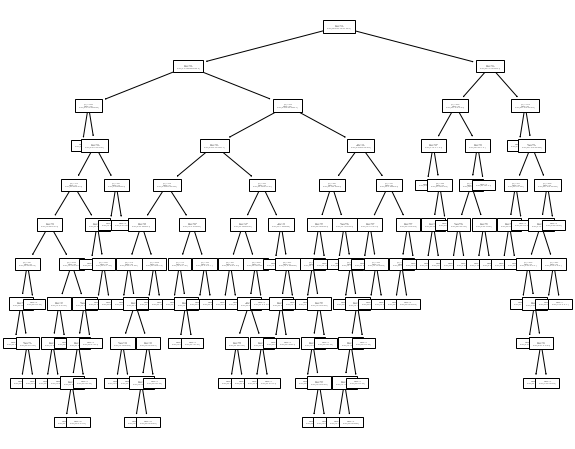

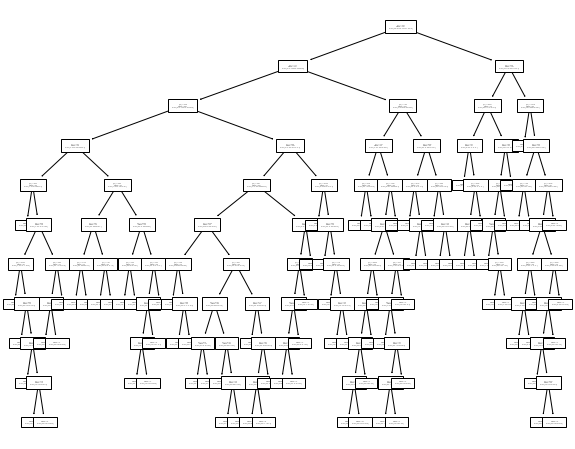

In [176]:
# Now to look at their structure
plt.figure(figsize=(10,8))
sklearn.tree.plot_tree(clf_tSNE_A1, fontsize=1, impurity=False);
#plt.savefig('tree_struct_tSNE_A1.png')
plt.figure(figsize=(10,8))
sklearn.tree.plot_tree(clf_tSNE_A2, fontsize=1, impurity=False);
#plt.savefig('tree_struct_tSNE_A2.png')

## Lastly, we can try reducing the dimension of the data using PCE, followed by t-SNE. Hopefully this hybrid dimension reduction technique will result in more robust classifiers, although the results will not be reproducible, due to the issues with t-SNE.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 14000 samples in 0.019s...
[t-SNE] Computed neighbors for 14000 samples in 0.433s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14000
[t-SNE] Computed conditional probabilities for sample 2000 / 14000
[t-SNE] Computed conditional probabilities for sample 3000 / 14000
[t-SNE] Computed conditional probabilities for sample 4000 / 14000
[t-SNE] Computed conditional probabilities for sample 5000 / 14000
[t-SNE] Computed conditional probabilities for sample 6000 / 14000
[t-SNE] Computed conditional probabilities for sample 7000 / 14000
[t-SNE] Computed conditional probabilities for sample 8000 / 14000
[t-SNE] Computed conditional probabilities for sample 9000 / 14000
[t-SNE] Computed conditional probabilities for sample 10000 / 14000
[t-SNE] Computed conditional probabilities for sample 11000 / 14000
[t-SNE] Computed conditional probabilities for sample 12000 / 14000
[t-SNE] Computed conditional probabilities for sam

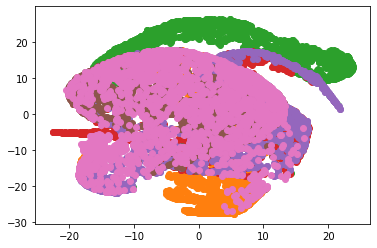

In [178]:
pca_RD_firststep = PCA(n_components=30, )
pca_RD_firststep.fit(X_train) # train the reduced PCA on the whole dataset
X_transf = pca_RD_firststep.transform(X_train)

tSNE_PCA = TSNE(n_components=3, learning_rate=200.0, n_iter=1000, n_iter_without_progress=300, \
                  min_grad_norm=1e-07, init='random', verbose=1 )

tSNE_PCA_fitted = tSNE_PCA.fit_transform(X_transf)

for i in range(7):
    idx = list(np.where(Y_train == i)[0])
    plt.scatter(tSNE_PCA_fitted[idx,0], tSNE_PCA_fitted[idx,1])
    
#plt.savefig('tSNE_data.pdf')

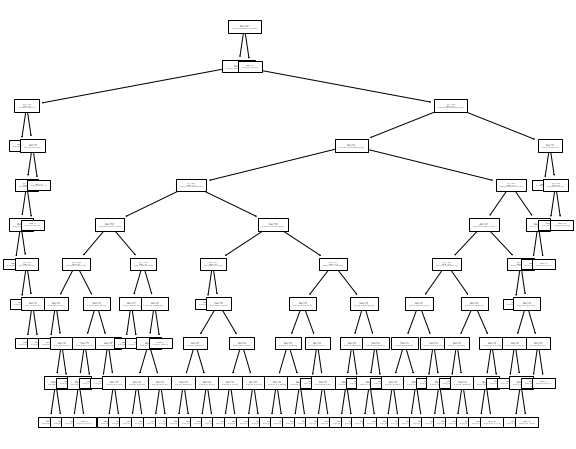

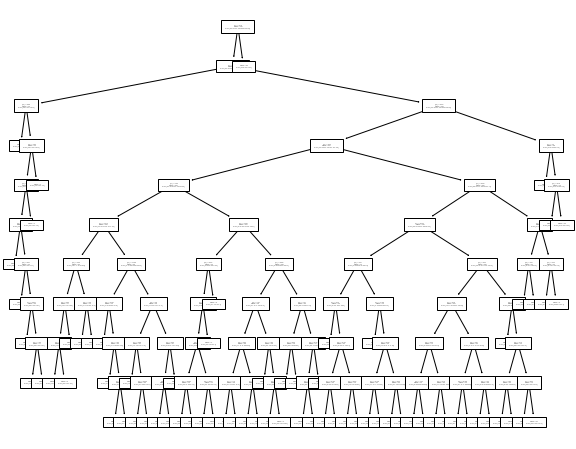

In [179]:
# Now to look at their structure
max_d = 10
min_samp = 100
split = int(len(Y_train)/2)
sub_A = np.random.choice(len(Y_train), split)
sub_B = np.random.choice(len(Y_train), split)

clf_tSNE_PCA_A = tree.DecisionTreeClassifier(max_depth=max_d, min_samples_split=min_samp)
clf_tSNE_PCA_A = clf_tSNE_PCA_A.fit(tSNE_PCA_fitted[sub_A,:], Y_train[sub_A])

clf_tSNE_PCA_B = tree.DecisionTreeClassifier(max_depth=max_d, min_samples_split=min_samp)
clf_tSNE_PCA_B = clf_tSNE_PCA_B.fit(tSNE_PCA_fitted[sub_B,:], Y_train[sub_B])

plt.figure(figsize=(10,8))
sklearn.tree.plot_tree(clf_tSNE_PCA_A, fontsize=1, impurity=False);
plt.figure(figsize=(10,8))
sklearn.tree.plot_tree(clf_tSNE_PCA_B, fontsize=1, impurity=False);

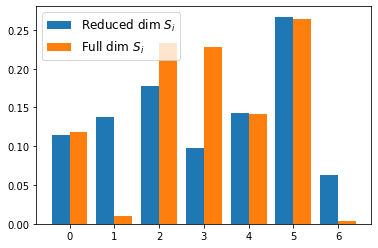

In [183]:
clf_metric_RD_A = ClassMetric(clf_tSNE_PCA_A, data=tSNE_PCA_fitted)
clf_metric_RD_B = ClassMetric(clf_tSNE_PCA_B, data=tSNE_PCA_fitted)

clf_metric_FD_A = ClassMetric(clf_FullD_A)
clf_metric_FD_B = ClassMetric(clf_FullD_B)

plt.bar(np.arange(7)-.2, clf_metric_RD_A,width=.4)
plt.bar(np.arange(7)+.2, clf_metric_FD_A,width=.4)
plt.legend(('Reduced dim $S_i$','Full dim $S_i$'),fontsize=12)
#plt.savefig('sensitivity_pca_tsne.pdf')

# Future Goals
1. Implement a more efficient and accurate Classifier Metric, requires some careful bookkeeping
2. Complete a systematic exploration of tSNE vs. PCA for dimension reduction
3. Explore other dimension reduction techniques, such as correlation-based